# exp005 エラー分析

## 概要
- **実験**: exp005_log_transform
- **CV MAPE**: 14.74% (exp004: 18.60%、改善: 3.86pt)
- **主な変更点**: 目的変数のlog1p変換

## 分析目標
1. 特徴量重要度の分析
2. 価格帯別の誤差分布
3. 高誤差サンプルの特徴
4. 改善提案

In [1]:
import sys
from pathlib import Path

# プロジェクトルート
project_root = Path.cwd().parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# seabornのスタイル設定（日本語フォントを指定）
sns.set_style('whitegrid')
sns.set(font="IPAexGothic")  # seabornで日本語フォントを明示的に指定

# japanize_matplotlib で日本語対応
import japanize_matplotlib

# グラフ設定
plt.rcParams['figure.figsize'] = (12, 6)

print(f"プロジェクトルート: {project_root}")

プロジェクトルート: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


In [2]:
# データ読み込み
output_dir = Path.cwd().parent / "outputs"

# 最新ファイルを取得
oof_files = sorted(output_dir.glob("oof_predictions_*.csv"))
importance_files = sorted(output_dir.glob("feature_importance_*.json"))

print(f"OOFファイル: {[f.name for f in oof_files]}")
print(f"重要度ファイル: {[f.name for f in importance_files]}")

# 最新を読み込み
oof_df = pl.read_csv(oof_files[-1])
with open(importance_files[-1], 'r') as f:
    importance_data = json.load(f)

print(f"\nOOFデータ形状: {oof_df.shape}")
oof_df.head()

OOFファイル: ['oof_predictions_20251125_213346.csv']
重要度ファイル: ['feature_importance_20251125_213346.json']

OOFデータ形状: (363924, 3)


id,actual,predicted
i64,i64,f64
0,13980000,1.7027e7
1,24480000,1.6541e7
2,24480000,2.0779e7
3,16300000,2.4692e7
4,18800000,1.8027e7


---
## 1. 特徴量重要度分析

In [3]:
# 重要度DataFrameを作成
importance_df = pd.DataFrame({
    'feature': importance_data['feature'],
    'importance': importance_data['importance']
}).sort_values('importance', ascending=False).reset_index(drop=True)

importance_df['rank'] = range(1, len(importance_df) + 1)
importance_df['cumulative_pct'] = importance_df['importance'].cumsum() / importance_df['importance'].sum() * 100

print("上位20特徴量:")
print(importance_df.head(20).to_string())

上位20特徴量:
                feature     importance  rank  cumulative_pct
0            year_built  195834.898131     1       13.807355
1            addr1_1_te  178882.886349     2       26.419508
2            house_area  122714.595843     3       35.071510
3       madori_kind_all   93141.410790     4       41.638453
4          building_age   84866.069167     5       47.621942
5                 post1   68362.592764     6       52.441852
6             unit_area   56556.141524     7       56.429348
7            addr1_2_te   52582.580221     8       60.136687
8               addr1_2   48644.292253     9       63.566357
9         money_kyoueki   43760.316642    10       66.651681
10                  lon   38347.754368    11       69.355393
11        addr1_1_count   34346.827564    12       71.777019
12                   el   33802.403770    13       74.160260
13     building_age_bin   28545.720561    14       76.172878
14                  lat   28454.539810    15       78.179068
15             

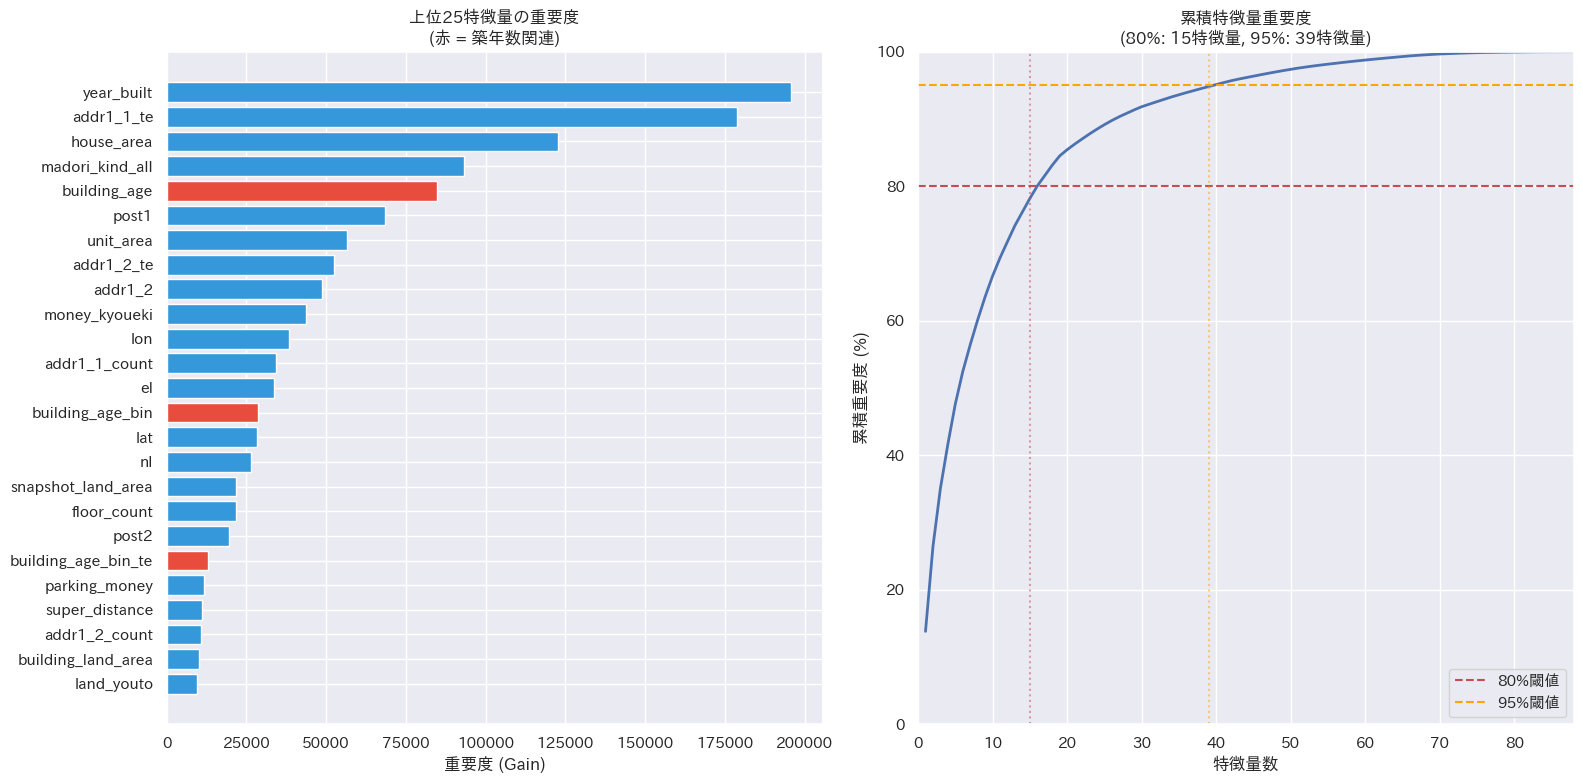


上位15特徴量で80%の重要度をカバー
上位39特徴量で95%の重要度をカバー


In [4]:
# 特徴量重要度の可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 上位25特徴量
top_n = 25
top_features = importance_df.head(top_n)

ax1 = axes[0]
colors = ['#e74c3c' if 'age' in f.lower() or 'old' in f.lower() else '#3498db' 
          for f in top_features['feature']]
ax1.barh(range(top_n), top_features['importance'].values[::-1], color=colors[::-1])
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features['feature'].values[::-1])
ax1.set_xlabel('重要度 (Gain)')
ax1.set_title(f'上位{top_n}特徴量の重要度\n(赤 = 築年数関連)')

# 累積重要度
ax2 = axes[1]
ax2.plot(importance_df['rank'], importance_df['cumulative_pct'], 'b-', linewidth=2)
ax2.axhline(y=80, color='r', linestyle='--', label='80%閾値')
ax2.axhline(y=95, color='orange', linestyle='--', label='95%閾値')

# 閾値を見つける
n_80 = (importance_df['cumulative_pct'] <= 80).sum()
n_95 = (importance_df['cumulative_pct'] <= 95).sum()
ax2.axvline(x=n_80, color='r', linestyle=':', alpha=0.5)
ax2.axvline(x=n_95, color='orange', linestyle=':', alpha=0.5)

ax2.set_xlabel('特徴量数')
ax2.set_ylabel('累積重要度 (%)')
ax2.set_title(f'累積特徴量重要度\n(80%: {n_80}特徴量, 95%: {n_95}特徴量)')
ax2.legend()
ax2.set_xlim(0, len(importance_df))
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(output_dir / 'feature_importance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n上位{n_80}特徴量で80%の重要度をカバー")
print(f"上位{n_95}特徴量で95%の重要度をカバー")

In [5]:
# 築年数関連特徴量の分析
age_features = ['building_age', 'building_age_bin', 'old_and_large_flag', 'old_and_rural_flag']

print("築年数関連特徴量:")
print("=" * 50)
for feat in age_features:
    row = importance_df[importance_df['feature'] == feat]
    if len(row) > 0:
        rank = row['rank'].values[0]
        imp = row['importance'].values[0]
        print(f"  {feat}: 順位 {rank}/88, 重要度 {imp:.2f}")

築年数関連特徴量:
  building_age: 順位 5/88, 重要度 84866.07
  building_age_bin: 順位 14/88, 重要度 28545.72
  old_and_large_flag: 順位 66/88, 重要度 1384.61
  old_and_rural_flag: 順位 54/88, 重要度 2008.23


---
## 2. 誤差分布分析

In [6]:
# 誤差を計算
oof = oof_df.to_pandas()
oof['error'] = oof['predicted'] - oof['actual']
oof['abs_error'] = np.abs(oof['error'])
oof['pct_error'] = np.abs(oof['error'] / oof['actual']) * 100
oof['signed_pct_error'] = (oof['error'] / oof['actual']) * 100

# 価格セグメント（10分位・5分位）
oof['price_decile'] = pd.qcut(oof['actual'], 10, labels=[f'D{i}' for i in range(1, 11)])
oof['price_quintile'] = pd.qcut(oof['actual'], 5, labels=[f'Q{i}' for i in range(1, 6)])

print("誤差統計:")
print(f"  平均APE: {oof['pct_error'].mean():.2f}%")
print(f"  中央値APE: {oof['pct_error'].median():.2f}%")
print(f"  標準偏差APE: {oof['pct_error'].std():.2f}%")
print(f"  最大APE: {oof['pct_error'].max():.2f}%")

誤差統計:
  平均APE: 14.74%
  中央値APE: 10.48%
  標準偏差APE: 16.16%
  最大APE: 442.77%


In [7]:
# 価格5分位別の誤差
quintile_stats = oof.groupby('price_quintile').agg({
    'actual': ['mean', 'min', 'max', 'count'],
    'pct_error': ['mean', 'median', 'std'],
    'signed_pct_error': 'mean'
}).round(2)

quintile_stats.columns = ['平均価格', '最小価格', '最大価格', '件数', 
                          'MAPE', '中央値APE', '標準偏差APE', 'バイアス']

# 高誤差率（>50%）
high_error_rate = oof.groupby('price_quintile').apply(
    lambda x: (x['pct_error'] > 50).mean() * 100
).round(2)
quintile_stats['高誤差率%'] = high_error_rate.values

print("価格5分位別の誤差:")
print("=" * 80)
print(quintile_stats.to_string())

価格5分位別の誤差:
                       平均価格      最小価格       最大価格     件数   MAPE  中央値APE  標準偏差APE   バイアス  高誤差率%
price_quintile                                                                               
Q1               9179770.96   4900000   12800000  76065  22.06   14.10    25.71  15.90  10.44
Q2              15664531.80  12810000   18500000  69985  14.38   10.85    13.78   2.12   2.09
Q3              21897171.17  18529800   25000000  73320  12.86    9.94    11.59  -0.78   1.09
Q4              29912183.35  25030900   34990000  72004  11.65    9.13    10.25  -2.79   0.62
Q5              53493047.38  35000000  188000000  72550  12.38    9.58    10.91  -5.73   0.99


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/2457729533.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_stats = oof.groupby('price_quintile').agg({
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/2457729533.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_error_rate = oof.groupby('price_quintile').apply(
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/2457729533.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excl

/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/3457040196.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_mape = oof.groupby('price_quintile')['pct_error'].mean()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/3457040196.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quintile_bias = oof.groupby('price_quintile')['signed_pct_error'].mean()


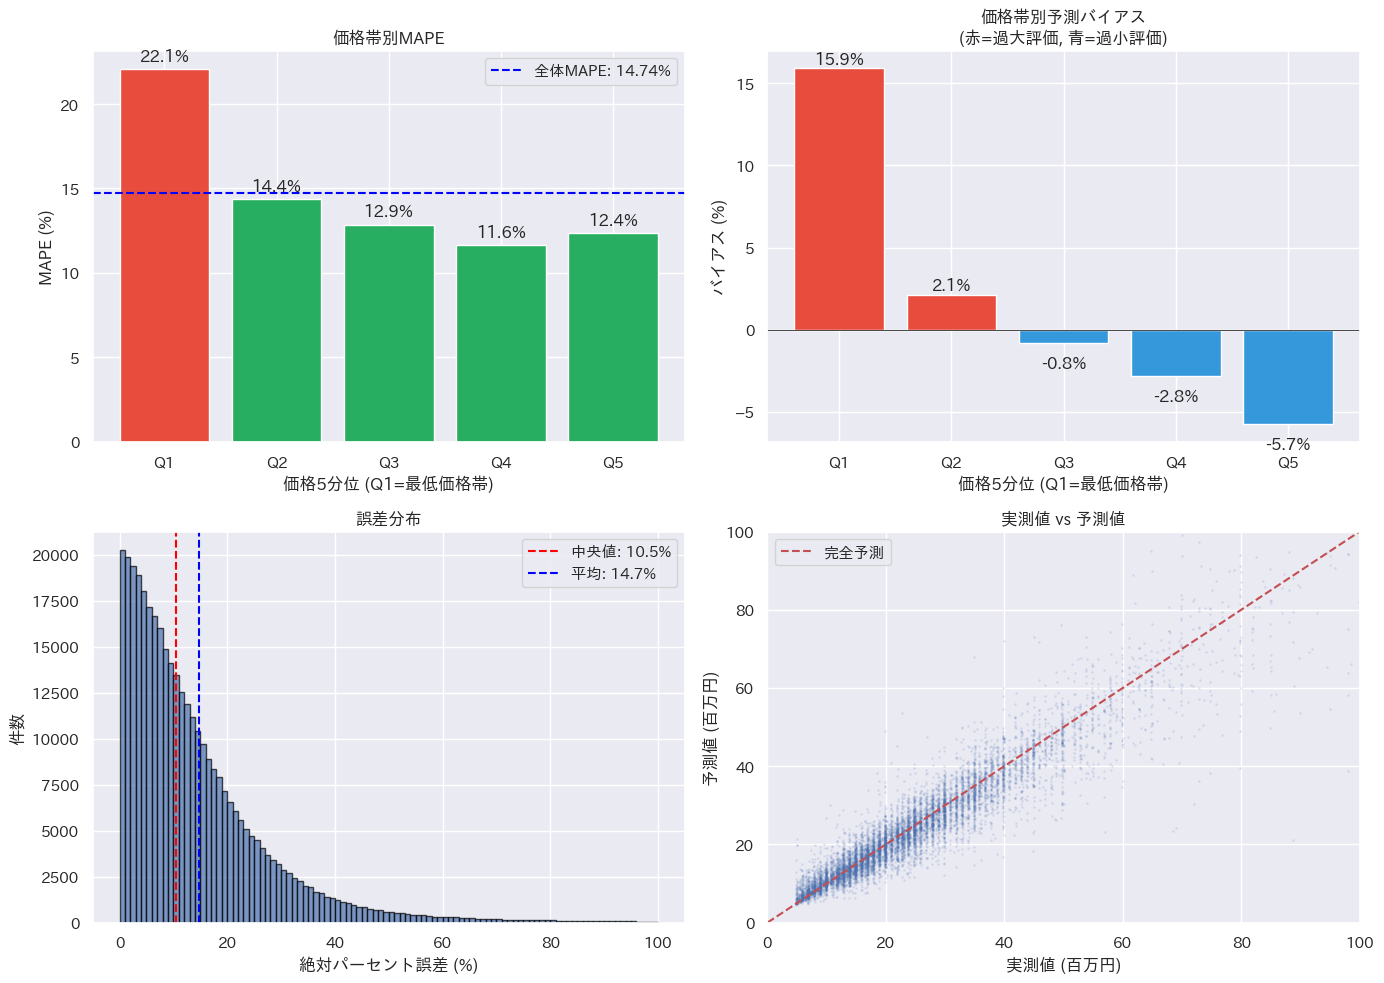

In [8]:
# 可視化：価格帯別の誤差
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 5分位別MAPE
ax1 = axes[0, 0]
quintile_mape = oof.groupby('price_quintile')['pct_error'].mean()
colors = ['#e74c3c' if v > 20 else '#f39c12' if v > 15 else '#27ae60' for v in quintile_mape]
ax1.bar(quintile_mape.index, quintile_mape.values, color=colors)
ax1.axhline(y=14.74, color='blue', linestyle='--', label=f'全体MAPE: 14.74%')
ax1.set_xlabel('価格5分位 (Q1=最低価格帯)')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('価格帯別MAPE')
ax1.legend()
for i, v in enumerate(quintile_mape.values):
    ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# 2. 5分位別バイアス
ax2 = axes[0, 1]
quintile_bias = oof.groupby('price_quintile')['signed_pct_error'].mean()
colors = ['#e74c3c' if v > 0 else '#3498db' for v in quintile_bias]
ax2.bar(quintile_bias.index, quintile_bias.values, color=colors)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('価格5分位 (Q1=最低価格帯)')
ax2.set_ylabel('バイアス (%)')
ax2.set_title('価格帯別予測バイアス\n(赤=過大評価, 青=過小評価)')
for i, v in enumerate(quintile_bias.values):
    ax2.text(i, v + 0.3 if v > 0 else v - 1.5, f'{v:.1f}%', ha='center')

# 3. 誤差分布
ax3 = axes[1, 0]
ax3.hist(oof['pct_error'], bins=100, range=(0, 100), edgecolor='black', alpha=0.7)
ax3.axvline(x=oof['pct_error'].median(), color='red', linestyle='--', 
            label=f'中央値: {oof["pct_error"].median():.1f}%')
ax3.axvline(x=oof['pct_error'].mean(), color='blue', linestyle='--', 
            label=f'平均: {oof["pct_error"].mean():.1f}%')
ax3.set_xlabel('絶対パーセント誤差 (%)')
ax3.set_ylabel('件数')
ax3.set_title('誤差分布')
ax3.legend()

# 4. 実測値 vs 予測値
ax4 = axes[1, 1]
sample = oof.sample(min(10000, len(oof)), random_state=42)
ax4.scatter(sample['actual']/1e6, sample['predicted']/1e6, alpha=0.1, s=1)
max_val = max(sample['actual'].max(), sample['predicted'].max()) / 1e6
ax4.plot([0, max_val], [0, max_val], 'r--', label='完全予測')
ax4.set_xlabel('実測値 (百万円)')
ax4.set_ylabel('予測値 (百万円)')
ax4.set_title('実測値 vs 予測値')
ax4.legend()
ax4.set_xlim(0, 100)
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(output_dir / 'error_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. 高誤差サンプル分析

In [9]:
# 高誤差サンプル (MAPE > 50%)
high_error = oof[oof['pct_error'] > 50].copy()
print(f"高誤差サンプル (APE > 50%): {len(high_error)}件 ({len(high_error)/len(oof)*100:.2f}%)")

# 価格5分位別の分布
print("\n高誤差サンプルの価格帯分布:")
he_by_quintile = high_error.groupby('price_quintile').size()
total_by_quintile = oof.groupby('price_quintile').size()
he_pct = (he_by_quintile / total_by_quintile * 100).round(2)

for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    count = he_by_quintile.get(q, 0)
    pct = he_pct.get(q, 0)
    share = count / len(high_error) * 100 if len(high_error) > 0 else 0
    print(f"  {q}: {count}件 (分位内{pct:.1f}%, 高誤差全体の{share:.1f}%)")

高誤差サンプル (APE > 50%): 11362件 (3.12%)

高誤差サンプルの価格帯分布:
  Q1: 7942件 (分位内10.4%, 高誤差全体の69.9%)
  Q2: 1460件 (分位内2.1%, 高誤差全体の12.8%)
  Q3: 796件 (分位内1.1%, 高誤差全体の7.0%)
  Q4: 446件 (分位内0.6%, 高誤差全体の3.9%)
  Q5: 718件 (分位内1.0%, 高誤差全体の6.3%)


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/909032475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  he_by_quintile = high_error.groupby('price_quintile').size()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/909032475.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_by_quintile = oof.groupby('price_quintile').size()


In [10]:
# 元データを読み込んで詳細分析
import yaml
from data.loader import DataLoader

config_path = project_root / "03_configs" / "data.yaml"
with open(config_path, "r", encoding="utf-8") as f:
    data_config = yaml.safe_load(f)

data_config["data"]["train_path"] = str(project_root / data_config["data"]["train_path"])
data_config["data"]["test_path"] = str(project_root / data_config["data"]["test_path"])
data_config["data"]["sample_submit_path"] = str(project_root / data_config["data"]["sample_submit_path"])

loader = DataLoader(config=data_config, add_address_columns=True)
train_full = loader.load_train().to_pandas()

# 誤差情報をマージ
train_full['idx'] = range(len(train_full))
oof['idx'] = oof['id']
merged = train_full.merge(oof[['idx', 'predicted', 'pct_error', 'signed_pct_error', 'price_quintile']], on='idx')

print(f"マージ後データ形状: {merged.shape}")

マージ後データ形状: (363924, 156)


In [11]:
# 高誤差サンプルの特徴比較
high_error_merged = merged[merged['pct_error'] > 50]
low_error_merged = merged[merged['pct_error'] <= 15]

print("特徴比較 (高誤差 vs 低誤差):")
print("=" * 60)

compare_cols = ['money_room', 'house_area', 'year_built', 'room_count', 
                'addr1_1', 'building_structure', 'floor_count']

for col in compare_cols:
    if col in merged.columns:
        if high_error_merged[col].dtype in ['int64', 'float64']:
            he_val = high_error_merged[col].mean()
            le_val = low_error_merged[col].mean()
            print(f"{col}:")
            print(f"  高誤差: {he_val:.2f}")
            print(f"  低誤差: {le_val:.2f}")
        else:
            he_mode = high_error_merged[col].mode()
            le_mode = low_error_merged[col].mode()
            he_val = he_mode.values[0] if len(he_mode) > 0 else 'N/A'
            le_val = le_mode.values[0] if len(le_mode) > 0 else 'N/A'
            print(f"{col}:")
            print(f"  高誤差: {he_val}")
            print(f"  低誤差: {le_val}")

特徴比較 (高誤差 vs 低誤差):
money_room:
  高誤差: 14384712.89
  低誤差: 26848546.32
house_area:
  高誤差: 129.51
  低誤差: 89.10
year_built:
  高誤差: 198646.10
  低誤差: 199473.42
room_count:
  高誤差: 3.72
  低誤差: 3.17
addr1_1:
  高誤差: 20.80
  低誤差: 19.92
building_structure:
  高誤差: 2.66
  低誤差: 3.30
floor_count:
  高誤差: 3.62
  低誤差: 6.57


In [12]:
# 都道府県別の高誤差分布
if 'prefecture_name' in merged.columns:
    print("\n都道府県別高誤差件数 (上位10):")
    he_pref = high_error_merged.groupby('prefecture_name').agg({
        'pct_error': ['count', 'mean']
    }).round(2)
    he_pref.columns = ['件数', '平均誤差']
    he_pref = he_pref.sort_values('件数', ascending=False).head(10)
    print(he_pref.to_string())


都道府県別高誤差件数 (上位10):
                   件数   平均誤差
prefecture_name             
神奈川県             1192  75.17
大阪府              1114  76.26
千葉県               991  73.99
兵庫県               985  76.61
埼玉県               972  71.97
東京都               880  72.85
愛知県               653  73.16
京都府               604  83.09
静岡県               508  79.73
福岡県               506  73.88


/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/3887680054.py:33: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) IPAexGothic.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_22455/3887680054.py:34: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) IPAexGothic.
  plt.savefig(output_dir / 'high_error_characteristics.png', dpi=150, bbox_inches='tight')


/Users/kotaro/Desktop/ML/20251122_signamte_mlit/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) IPAexGothic.
  fig.canvas.print_figure(bytes_io, **kw)


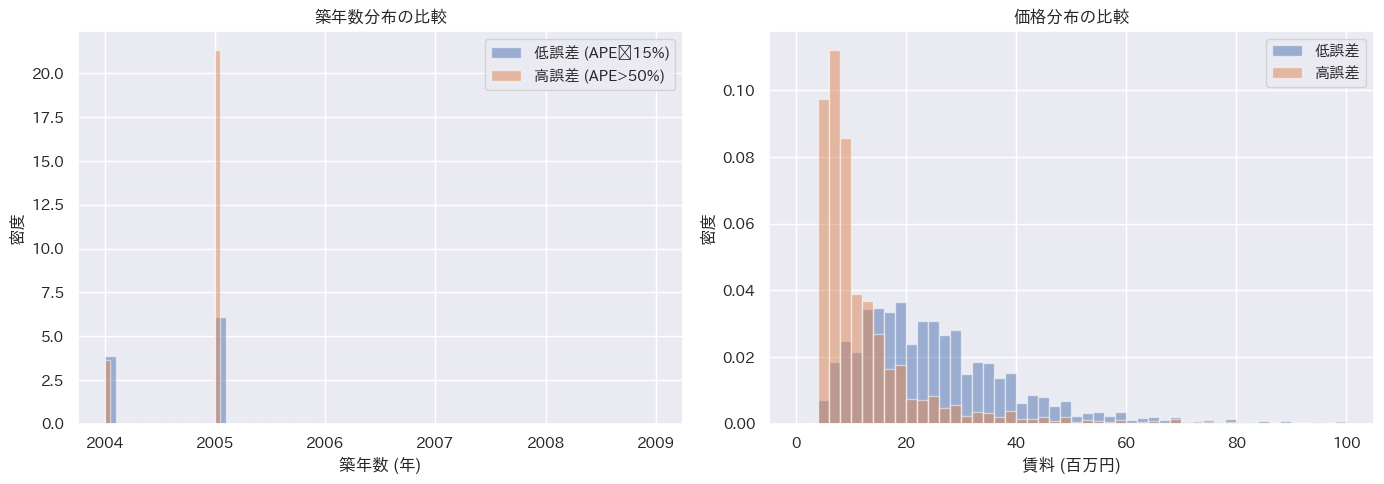

In [13]:
# 築年数と価格の分布比較
# building_ageカラムを追加（year_builtはYYYYMM形式）
merged['building_age'] = 2024 - merged['year_built'] // 10000

# high_error_merged, low_error_merged を再定義
high_error_merged = merged[merged['pct_error'] > 50]
low_error_merged = merged[merged['pct_error'] <= 15]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 築年数分布
ax1 = axes[0]
ax1.hist(low_error_merged['building_age'].dropna(), bins=50, alpha=0.5, 
         label='低誤差 (APE≤15%)', density=True)
ax1.hist(high_error_merged['building_age'].dropna(), bins=50, alpha=0.5, 
         label='高誤差 (APE>50%)', density=True)
ax1.set_xlabel('築年数 (年)')
ax1.set_ylabel('密度')
ax1.set_title('築年数分布の比較')
ax1.legend()

# 価格分布
ax2 = axes[1]
ax2.hist(low_error_merged['money_room']/1e6, bins=50, alpha=0.5, 
         label='低誤差', density=True, range=(0, 100))
ax2.hist(high_error_merged['money_room']/1e6, bins=50, alpha=0.5, 
         label='高誤差', density=True, range=(0, 100))
ax2.set_xlabel('賃料 (百万円)')
ax2.set_ylabel('密度')
ax2.set_title('価格分布の比較')
ax2.legend()

plt.tight_layout()
plt.savefig(output_dir / 'high_error_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. exp004との比較

In [14]:
# exp004の結果を読み込み（あれば）
exp004_dir = project_root / "06_experiments" / "exp004_age_features" / "outputs"
exp004_oof_files = sorted(exp004_dir.glob("oof_predictions_*.csv"))

if exp004_oof_files:
    exp004_oof = pl.read_csv(exp004_oof_files[-1]).to_pandas()
    exp004_oof['pct_error'] = np.abs((exp004_oof['predicted'] - exp004_oof['actual']) / exp004_oof['actual']) * 100
    exp004_oof['price_quintile'] = pd.qcut(exp004_oof['actual'], 5, labels=[f'Q{i}' for i in range(1, 6)])
    
    print("比較: exp004 vs exp005")
    print("=" * 60)
    
    comparison_data = []
    for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
        exp004_mape = exp004_oof[exp004_oof['price_quintile'] == q]['pct_error'].mean()
        exp005_mape = oof[oof['price_quintile'] == q]['pct_error'].mean()
        improvement = exp004_mape - exp005_mape
        comparison_data.append({
            '価格帯': q,
            'exp004': f'{exp004_mape:.2f}%',
            'exp005': f'{exp005_mape:.2f}%',
            '改善': f'{improvement:.2f}pt'
        })
        print(f"{q}: exp004={exp004_mape:.2f}% -> exp005={exp005_mape:.2f}% (改善: {improvement:.2f}pt)")
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))
else:
    print("exp004のOOF予測ファイルが見つかりません")

比較: exp004 vs exp005
Q1: exp004=32.83% -> exp005=22.06% (改善: 10.78pt)
Q2: exp004=18.01% -> exp005=14.38% (改善: 3.63pt)
Q3: exp004=15.05% -> exp005=12.86% (改善: 2.19pt)
Q4: exp004=13.00% -> exp005=11.65% (改善: 1.36pt)
Q5: exp004=13.40% -> exp005=12.38% (改善: 1.03pt)

価格帯 exp004 exp005      改善
 Q1 32.83% 22.06% 10.78pt
 Q2 18.01% 14.38%  3.63pt
 Q3 15.05% 12.86%  2.19pt
 Q4 13.00% 11.65%  1.36pt
 Q5 13.40% 12.38%  1.03pt


---
## 5. まとめと改善提案

In [15]:
# サマリー統計
print("="*70)
print("exp005 エラー分析サマリー")
print("="*70)

print("\n【全体性能】")
print(f"  CV MAPE: 14.74% (exp004: 18.60%、改善: 3.86pt)")
print(f"  中央値APE: {oof['pct_error'].median():.2f}%")
print(f"  高誤差率 (>50%): {(oof['pct_error'] > 50).mean()*100:.2f}%")

print("\n【価格帯別誤差】")
for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    mape = oof[oof['price_quintile'] == q]['pct_error'].mean()
    bias = oof[oof['price_quintile'] == q]['signed_pct_error'].mean()
    status = "⚠️ 要改善" if mape > 20 else "✓ OK"
    print(f"  {q}: MAPE={mape:.2f}%, バイアス={bias:+.2f}% {status}")

print("\n【上位5特徴量】")
for i, row in importance_df.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.0f}")

print("\n【改善提案】")
print("  1. n_estimators増加 (15000 -> 20000): Early stoppingが未到達")
print("  2. Q1（低価格帯）の誤差がまだ大きい:")
print("     - 2段階モデル（低価格/高価格で分離）")
print("     - 低価格帯のサンプル重み付け")
print("  3. 特徴量追加: 駅からの距離、地域クラスタ")
print("  4. 別の変換を試す: sqrt, Box-Cox")
print("="*70)

exp005 エラー分析サマリー

【全体性能】
  CV MAPE: 14.74% (exp004: 18.60%、改善: 3.86pt)
  中央値APE: 10.48%
  高誤差率 (>50%): 3.12%

【価格帯別誤差】
  Q1: MAPE=22.06%, バイアス=+15.90% ⚠️ 要改善
  Q2: MAPE=14.38%, バイアス=+2.12% ✓ OK
  Q3: MAPE=12.86%, バイアス=-0.78% ✓ OK
  Q4: MAPE=11.65%, バイアス=-2.79% ✓ OK
  Q5: MAPE=12.38%, バイアス=-5.73% ✓ OK

【上位5特徴量】
  1. year_built: 195835
  2. addr1_1_te: 178883
  3. house_area: 122715
  4. madori_kind_all: 93141
  5. building_age: 84866

【改善提案】
  1. n_estimators増加 (15000 -> 20000): Early stoppingが未到達
  2. Q1（低価格帯）の誤差がまだ大きい:
     - 2段階モデル（低価格/高価格で分離）
     - 低価格帯のサンプル重み付け
  3. 特徴量追加: 駅からの距離、地域クラスタ
  4. 別の変換を試す: sqrt, Box-Cox


In [16]:
# サマリーをMarkdownで保存
summary_md = f"""
# exp005 エラー分析サマリー

## 全体性能
| 指標 | 値 |
|--------|-------|
| CV MAPE | 14.74% |
| exp004 MAPE | 18.60% |
| 改善幅 | 3.86pt |
| 中央値APE | {oof['pct_error'].median():.2f}% |
| 高誤差率 (>50%) | {(oof['pct_error'] > 50).mean()*100:.2f}% |

## 価格帯別誤差
| 価格帯 | MAPE | バイアス | 状態 |
|----------|------|------|--------|
"""

for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    mape = oof[oof['price_quintile'] == q]['pct_error'].mean()
    bias = oof[oof['price_quintile'] == q]['signed_pct_error'].mean()
    status = "要改善" if mape > 20 else "OK"
    summary_md += f"| {q} | {mape:.2f}% | {bias:+.2f}% | {status} |\n"

summary_md += """
## 改善提案
1. **n_estimators増加**: 15000 -> 20000 (early stopping未到達)
2. **Q1対策**: 2段階モデル or サンプル重み付け
3. **特徴量追加**: 駅距離、地域クラスタ
4. **別変換**: sqrt, Box-Cox
"""

with open(output_dir / 'error_analysis_summary.md', 'w', encoding='utf-8') as f:
    f.write(summary_md)

print("サマリーを error_analysis_summary.md に保存しました")

サマリーを error_analysis_summary.md に保存しました
